## Requête 1: liste des acteurs par film


In [1]:
# import des librairies
import os
import pandas as pd 
import numpy as np

In [2]:

# lire les fichiers .tsv vers un dataframe
df_name_basics = pd.read_csv('../name.basics.tsv', sep="\t", usecols=["nconst", "primaryName"])

#df_name_basics = df_name_basics[["nconst", "primaryName", "knownForTitles"]]
#
df_principals = pd.read_csv('../title.principals.tsv', sep="\t") 
#
df_principals = df_principals.loc[(df_principals['category']=="actor")|(df_principals['category']=="actress"),:]
df_principals = df_principals[["tconst", "nconst"]]
# inner join with merge
df_merged_inner = pd.merge(left = df_principals, right= df_name_basics, left_on='nconst', right_on='nconst')
#lire title.basics


In [3]:
# lire le fichier title.basics.tsv
df_title_basics = pd.read_csv('../title.basics.tsv', sep="\t")
# mettre un filtre sur titleType
df_title_basics = df_title_basics.loc[(df_title_basics['titleType']=="tvMovie")|(df_title_basics['titleType']=="movie"),:]
# select interesting columns
df_title_filtred = df_title_basics[["tconst", "primaryTitle"]] 
#faire un merge
liste_actor = pd.merge(left=df_title_filtred, right = df_merged_inner, left_on = 'tconst', right_on = 'tconst', how = 'inner')
liste_actor = liste_actor[["primaryTitle","primaryName"]]
#
#liste_actor.to_csv('liste_actor.csv', sep =",")
#groupby
liste_actors = liste_actor.groupby(['primaryTitle'])['primaryName'].apply(','.join).reset_index()
liste_actors.to_csv('liste_actors.csv', sep =",")
#print(liste_actors.head())

## Requête 2: liste des films américains avec leurs titres en français et leur moyenne

In [4]:
# lire le fichier.tsv
df_title_akas = pd.read_csv('../title.akas.tsv', sep="\t", usecols=["titleId", "title", "region"])
#
df_title_akas_US = df_title_akas.loc[(df_title_akas['region']=="US"),:]
#
df_title_akas_US = df_title_akas_US.rename(columns={'region':'region_US'})
#
df_title_akas_FR = df_title_akas.loc[(df_title_akas['region']=="FR"),:]
#
df_title_akas_FR = df_title_akas_FR.rename(columns={'title': 'title_french','region':'region_FR'})
#merge des deux fichiers df_title_akas_US et df_title_akas_FR
df_title_filtred_akas = pd.merge(left= df_title_akas_US, right = df_title_akas_FR, left_on = 'titleId', right_on = 'titleId', how = 'left')
# selection des colonnes intéressantes
df_title_filtred_akas = df_title_filtred_akas[["titleId", "title_french", "title"]]
# nettoyage du dataframe df_title_filtred
df_title_filtred_akas['title'] = np.where(df_title_filtred_akas['title_french'].notnull(), '', df_title_filtred_akas['title'])
#
df_title_filtred_akas = df_title_filtred_akas.rename(columns ={'titleId': 'tconst'})
# faire un merge avec la liste des films filtrés (movie et intermvie)
df_title_filtred = df_title_basics[["tconst"]] 
#
df_title_filtred_akas =pd.merge(left = df_title_filtred, right = df_title_filtred_akas, left_on = 'tconst', right_on = 'tconst', how = 'inner')



In [5]:
df_title_rating = pd.read_csv('../title.ratings.tsv', sep="\t", usecols=["tconst", "averageRating"])
# merge des deux fichiers df_title_rating et df_title_filtred_akas
liste_film_americain = pd.merge(left = df_title_filtred_akas, right = df_title_rating, left_on = 'tconst', right_on = 'tconst', how = 'inner')


## Requête 3: les notes moyennes des différents genres

In [6]:
df_title_basics_2 = df_title_basics[["tconst","genres"]] 
#
df_title_basics_2 = pd.DataFrame(df_title_basics_2.genres.str.split(',').tolist(), index=df_title_basics_2.tconst).stack()
df_title_basics_2 =df_title_basics_2.reset_index([0, 'tconst'])
df_title_basics_2.columns = ['tconst', 'genres']
# récupération des notes par un merge
note_genre = pd.merge(left = df_title_basics_2, right = df_title_rating, left_on = 'tconst', right_on = 'tconst', how = 'inner')



## Requête 4: la note moyenne de chaque acteur par rapport aux films dans lesquels il apparait

In [7]:
#merge des fichiers df_merged_inner et df_title_rating
note_actor = pd.merge(left = df_merged_inner, right = df_title_rating, left_on = 'tconst', right_on = 'tconst', how = 'inner')
note_actor = note_actor[["primaryName", "averageRating"]]
# 
moyenne_actor = note_actor.groupby('primaryName')['averageRating'].mean()

## Bonus 3: prédire les notes moyennes d'un film
### préparation des données

In [8]:
df_title_basics_3 = df_title_basics[["tconst", "primaryTitle", "titleType", "genres", "isAdult", "startYear", "runtimeMinutes"]]

df_title_rating_3 = pd.read_csv('../title.ratings.tsv', sep="\t", usecols=["tconst", "averageRating", "numVotes"])
df_title_akas_3 = pd.read_csv('../title.akas.tsv', sep="\t", usecols=["titleId", "region"])
df_title_akas_3 = df_title_akas_3.rename(columns={'titleId': 'tconst'})
#merge des dataframes df_title_basics_3 et df_title_rating_3
df_title_3 = pd.merge(left = df_title_basics_3, right = df_title_rating_3, left_on = 'tconst', right_on = 'tconst', how = 'inner')
# merge entre df_title_3 et df_title_akas_3
df_bonus_3 = pd.merge(left = df_title_3, right = df_title_akas_3, left_on = 'tconst', right_on = 'tconst', how = 'inner')
df_bonus_3 = pd.merge(left = df_merged_inner, right = df_bonus_3, left_on = 'tconst', right_on = 'tconst', how = 'inner')
#nettoyage du dataframe df_bonus_3




In [10]:
#
df_bonus_3 = df_bonus_3[~df_bonus_3.genres.str.contains('N')]
df_bonus_3 = df_bonus_3[~df_bonus_3.runtimeMinutes.str.contains('N')]
df_bonus_3 = df_bonus_3[~df_bonus_3.region.str.contains('N', na=False)]


In [12]:
df_bonus_3 = df_bonus_3[~df_bonus_3.startYear.str.contains('N', na=False)]
#df_bonus_3 = df_bonus_3[~df_bonus_3.numVotes.str.contains('N')]
##

## Application d'un algorithme de regression linéaire

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt


&lt;AxesSubplot:&gt;

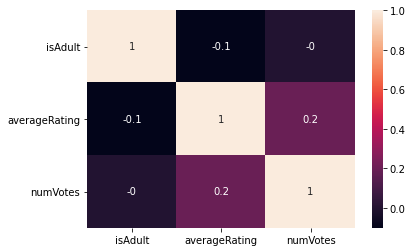

In [14]:
# trouver des corrélations du paramètre "averageRating" avec les autres paramètres
df_bonus_3.corr()["averageRating"]
matrice_corr = df_bonus_3.corr().round(1)
sns.heatmap(data = matrice_corr, annot=True)


Text(0, 0.5, &#39;count&#39;)

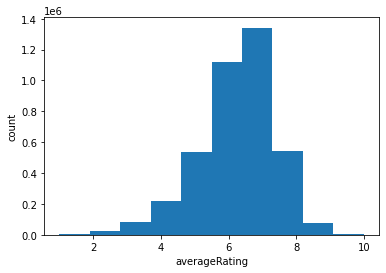

In [16]:
plt.hist(df_bonus_3["averageRating"])
plt.xlabel('averageRating')
plt.ylabel('count')

In [15]:
columns = df_bonus_3.columns.tolist()
columns = [c for c in columns if c not in ["tconst", "nconst", "primaryName", "primaryTitle","titleType","genres","region"]]
#stocker la variable à prédire
target = "averageRating"
# générer l'ensemble de données pour l'apprentissage, définir un état aléatoire pour reproduire les résultats
train = df_bonus_3.sample(frac=0.8, random_state=1)

# selectionner un autre ensemble qui n'est pas dans l'apprentissage
test = df_bonus_3.loc[~df_bonus_3.index.isin(train.index)]
# Initialiser la classe du modèle
lin_model = LinearRegression()
#
print(train.shape)
print(test.shape)
# Ajuster le modèle aux données d'apprentissage (fit the model to the training data)
lin_model.fit(train[columns], train[target])
# générer les predictions
lin_predictions = lin_model.predict(test[columns])
print("Predictions:", lin_predictions)
# calcul d'erreur entre les prédictions et les valeurs fournies
lin_mse = mean_squared_error(lin_predictions, test[target])
print("Computed error:", lin_mse)

(3167351, 12)
(791838, 12)
Predictions: [3.  3.  5.4 ... 7.8 7.8 7.8]
Computed error: 2.1841866443618504e-29
